Generate from a gamma
Individual PCA, correlate with globak PCA, corr to 1, subjects closer 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import joblib
import os.path as op
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import sample
import xarray as xr
import pyhsmm_mvpa as hsmm
import seaborn as sns
import pandas as pd
import multiprocessing

cpus = multiprocessing.cpu_count()

n_events = 600
sources = [['lateraloccipital-lh',1e-8, [np.random.gamma,2,50]],
           ['lateraloccipital-rh', 1e-8, [np.random.gamma, 2,150]],
           ['postcentral-lh', 1e-8, [np.random.gamma, 2, 80]],
           ['posteriorcingulate-rh', 1e-8, [np.random.gamma, 2,50]],
           ['postcentral-rh', 1e-8, [np.random.gamma, 2,100]],
           ['postcentral-lh', 1e-25, [np.random.gamma, 2,50]]]#Response trigger, amplitude scale make it hardly visible for hsmm

max_trial_length = 4000#ms

bump_frequency = 10.
file =  'simulated-raw.fif'
if file in os.listdir():
    raw = mne.io.read_raw_fif(file)
    generating_events = np.load(file+'generating_events.npy')
else:
    # Following code and comments largely comes from MNE examples (e.g. https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html)
    # For this example, we will be using the information of the sample subject.
    # This will download the data if it not already on your machine. We also set
    # the subjects directory so we don't need to give it to functions.
    data_path = sample.data_path()
    subjects_dir = op.join(data_path, 'subjects')
    subject = 'sample'

    # First, we get an info structure from the test subject.
    evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    info = mne.io.read_info(evoked_fname)
    #info = info.pick_channels(info.ch_names[-61:])
    tstep = 1. / info['sfreq']

    # To simulate sources, we also need a source space. It can be obtained from the
    # forward solution of the sample subject.
    fwd_fname = op.join(data_path, 'MEG', subject,
                        'sample_audvis-meg-eeg-oct-6-fwd.fif')
    fwd = mne.read_forward_solution(fwd_fname)
    #fwd = fwd.pick_channels(info.ch_names[-61:])
    src = fwd['src']

    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep, first_samp=0, duration=(2+1*n_events+3)*max_trial_length*tstep)

    # stim_onset occurs every x samples.
    events = np.zeros((n_events, 3), int)
    stim_onsets =  2000+max_trial_length * np.arange(n_events)#2000 = offset of first stim
    events[:,0] = stim_onsets#last event 
    
    trigger = 1
    random_source_times = []
    generating_events = events
    for source in sources:
        selected_label = mne.read_labels_from_annot(
            subject, regexp=source[0], subjects_dir=subjects_dir)[0]
        label = mne.label.select_sources(
            subject, selected_label, location='center', extent=10,# Extent in mm of the region.
            subjects_dir=subjects_dir)

        # Define the time course of the activity for each source of the region to
        # activate.
        source_time_series = np.sin(2. * np.pi * bump_frequency * np.arange(25) * tstep) * source[1]

    
        #adding source event
        events = events.copy()
        rand_i = source[2][0](source[2][1],source[2][2],n_events)
        random_source_times.append(rand_i) #varying event 
        events[:, 0] = events[:,0] + random_source_times[-1] # Events sample.
        events[:, 2] = trigger  # All events have the sample id.
        trigger += 1
        generating_events = np.concatenate([generating_events, events])

        #add these events
        source_simulator.add_data(label, source_time_series, events)
 
    generating_events = generating_events[generating_events[:, 0].argsort()]
    # Project the source time series to sensor space and add some noise. The source
    # simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd, n_jobs=cpus,verbose=False)
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
    #raw.plot()

    raw.save(file, overwrite=True)
    np.save(file.split('.')[0]+'_generating_events.npy', generating_events)

Opening raw data file simulated-raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Range : 0 ... 2419999 =      0.000 ...  4029.202 secs
Ready.


In [2]:
number_of_sources = len(np.unique(generating_events[:,2])[1:])
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

resp_trigger = int(np.max(np.unique(generating_events[:,2])))

i,x = 1,0                  
while x <len(random_source_times):
    for j in np.arange(number_of_sources):
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == resp_trigger)]
raw = mne.io.read_raw_fif(file, preload=False)
event_id = {'stimulus':0}
resp_id = {'response':resp_trigger}
eeg_dat = hsmm.read_mne_EEG([file,], event_id, resp_id, raw.info['sfreq'],events)
hsmm_dat, PCs, explained_var, means = hsmm.transform_data(eeg_dat.data,'',
        apply_standard=False,single=True, return_weights=True, n_comp=4)
hsmm_dat = hsmm.stack_data(hsmm_dat,'',single=True)

Opening raw data file simulated-raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Range : 0 ... 2419999 =      0.000 ...  4029.202 secs
Ready.
Reading 0 ... 2419999  =      0.000 ...  4029.202 secs...
Adding metadata with 2 columns
600 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Using data from preloaded Raw for 600 events and 3124 original time points ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0.001 and 5 seconds


# Estimating a x bump model

Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


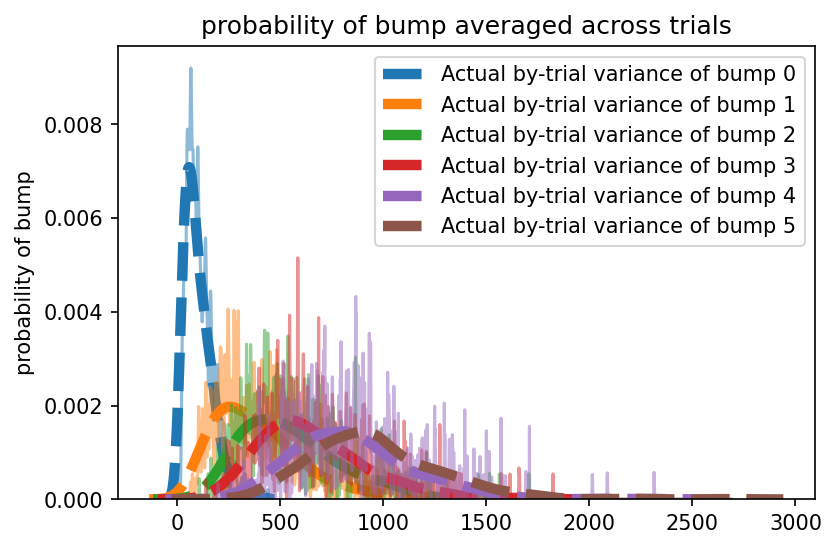

<xarray.DataArray 'parameters' (stage: 6)>
array([ 1.84576236, -0.45383305,  1.38200624, -2.68639379,  2.76840803,
       -2.85594979])
Dimensions without coordinates: stage


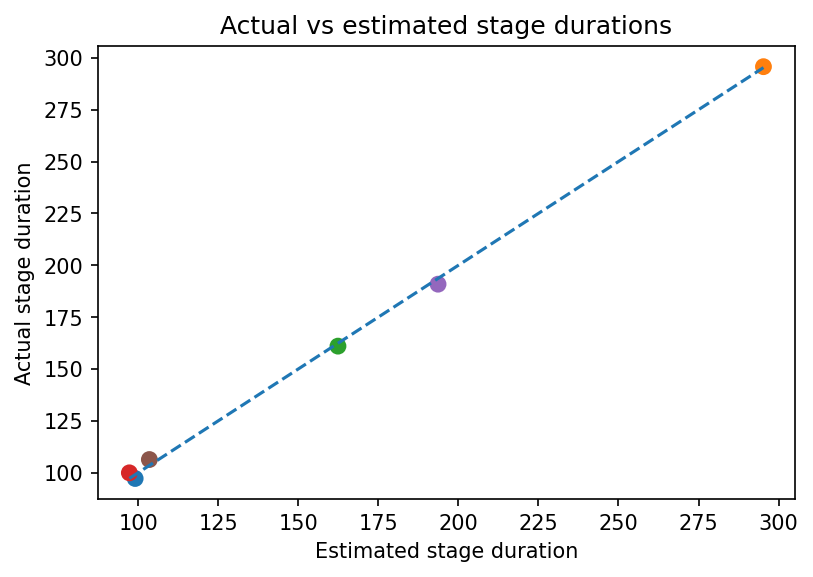

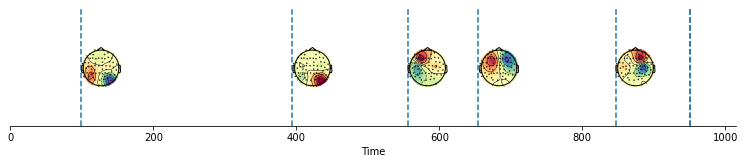

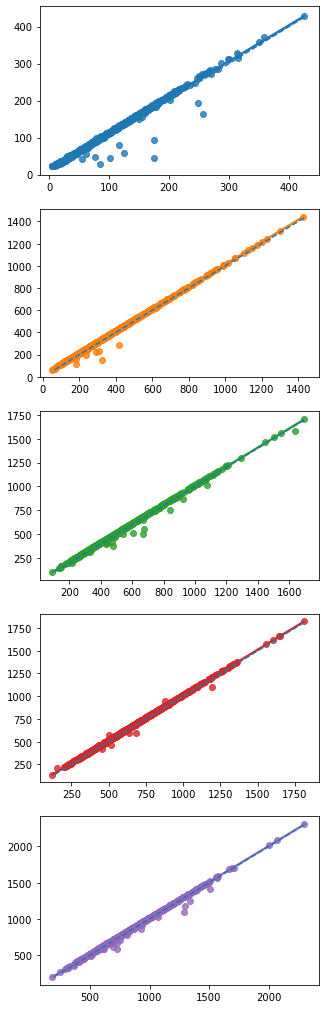

In [3]:
init = hsmm.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=5)
estimates = init.fit_single(number_of_sources-1)

plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
for i in range(len(random_source_times.T)):
    if i <=estimates.eventprobs.mean(dim=['trial']).bump.max():
        plt.plot(estimates.eventprobs.mean(dim=['trial']).sel(bump=i), color=colors[i],alpha=.5);
    sns.kdeplot(np.sum(random_source_times[:,:i+1],axis=1),lw=5, color=colors[i]
                ,ls='--',label=f'Actual by-trial variance of bump {i}')
plt.legend()
plt.title('probability of bump averaged across trials')
plt.ylabel('probability of bump')
plt.show()
plt.figure(dpi=150)

print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(30,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(30,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

positions = np.delete(mne.channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.reconstruct(estimates.magnitudes, PCs, explained_var, means)

hsmm.plot_topo_timecourse(electrodes, init.mean_bump_times(estimates.eventprobs), positions,#inferring electrode location, 
        bump_size=30, time_step = 1, magnify=1, figsize=(13,2),
        mean_rt = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]))

fig, ax= plt.subplots(5,1, figsize=(5,3*number_of_sources))
i = 0
gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
    i+= 1

## Iterative estimates

### Forward method

In [4]:
with multiprocessing.Pool(processes=cpus) as pool:
    iterative_results = pool.map(init.fit_single, np.arange(1,init.max_bumps+1))
iterative_results = xr.concat(iterative_results,  pd.Series(np.arange(1,init.max_bumps+1), name='n_bumps'))


Estimating parameters for 1 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 7 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 7 bumps model


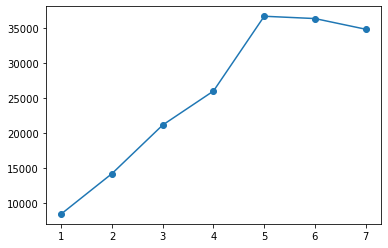

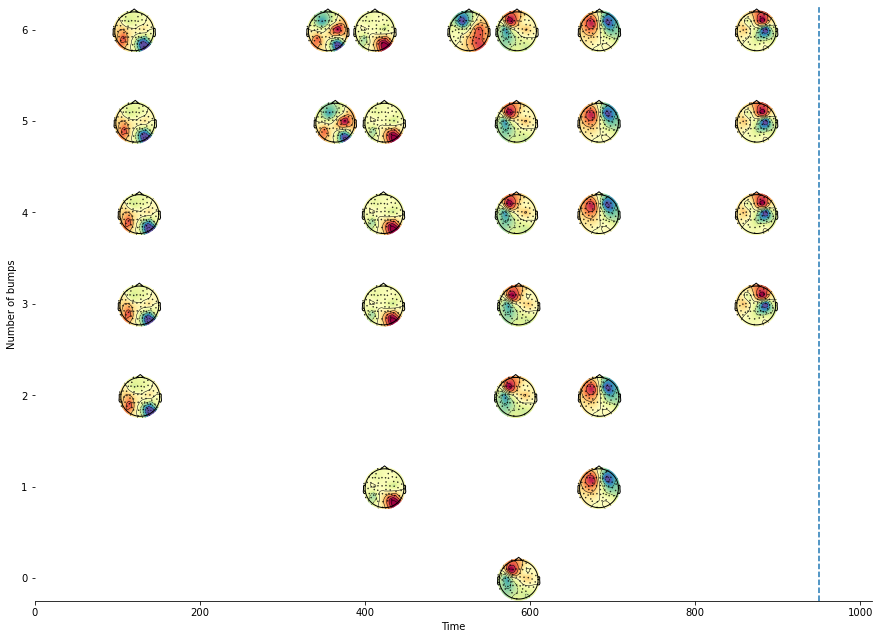

In [6]:
plt.plot(np.arange(1,init.max_bumps+1), iterative_results.likelihoods,'o-')
plt.show()

electrodes = hsmm.reconstruct(iterative_results.magnitudes, PCs, explained_var, means)

hsmm.plot_topo_timecourse(electrodes, init.mean_bump_times(iterative_results.eventprobs), positions,
    bump_size=30, time_step = 1, magnify=1, mean_rt = np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps)})

### Backward method

In [7]:
bests = init.backward_estimation(max_starting_points=2)
bests

Estimating all solutions for maximal number of bumps (7) with 1 random starting points
Estimating parameters for 7 bumps model
Parameters estimated for 7 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 7, stage: 8, params: 2, component: 4, bump: 7,
                  samples: 2687, trial: 600)
Coordinates:
  * n_bumps      (n_bumps) int64 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 3.487e+04 3.64e+04 ... 1.983e+04 8.619e+03
    parameters   (n_bumps, stage, params) float64 2.0 45.49 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.9533 -0.2494 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

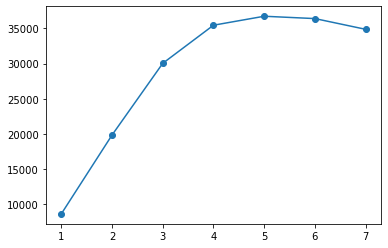

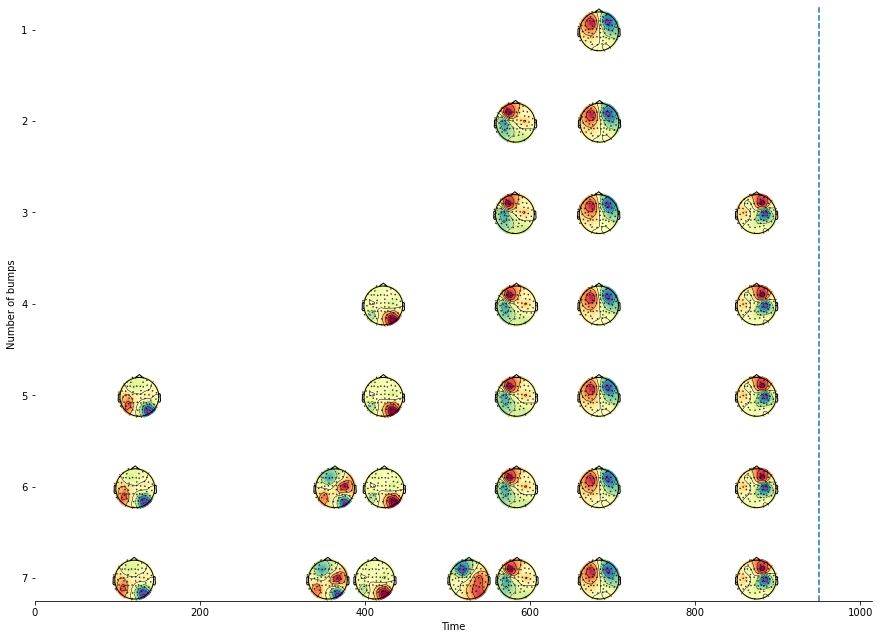

In [8]:
plt.plot(np.arange(init.max_bumps,0,-1), bests.likelihoods,'o-')
plt.show()

electrodes = hsmm.reconstruct(bests.magnitudes, PCs, explained_var, means)

hsmm.plot_topo_timecourse(electrodes, init.mean_bump_times(bests.eventprobs), positions,
    bump_size=30, time_step = 1, magnify=1, mean_rt = np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})